# Dynamic mode decomposition with control (DMDc) for a 128D system

DMDc aims to disambiguate the effect of control/actuation from the unforced dynamics. 

We illustrate DMDc for system identification on a high-dimensional, linear, spectrally sparse system. (this is example 3 in Sec. 4 in Proctor et al., _"Dynamic Mode Decomposition with Control"_, SIAM 2016). Consider a state on a two-dimensional manifold discretized on a $N \times N$ mesh $\mathbf{x} \in \mathbb{R}^{N \times N}$, where each entry, $i$-th row, $j$-th column of the square matrix $\mathbf{x}$ is denoted as $x(i,j) \in \mathbb{R}$. We further denote $\tilde{\mathbf{x}} \in \mathbb{R}^{N^2 \times 1}$ as the flattened vector. Moreover, let's denote $\hat{\mathbf{x}}$ as the 2D Discrete Fourier Transform of $\mathbf{x}$, and $\hat{x}(i,j)$ as the $i$-th row, $j$-th column entry of $\hat{\mathbf{x}}$. Following the definition of DFT, given $\textrm{j}^2+1=0$, we have 
$$ \hat{{x}}(i,j) = \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} x(m,n) e^{-\textrm{j} 2\pi \frac{i m + j n}{N}} $$

In the following, we create a **sparse linear dynamics** in the **spectral** space, i.e., $\hat{\mathbf{x}}$ rather than $\mathbf{x}$. Each mode in the spectral space is randomly picked as two random integers from $\{1,\ldots,\textrm{ceil}(N/(f_{max}+1))\}$. We will pick $S$ of such (different) integer pair. For simplicity, we denote those indices as $(i_1,j_1),\ldots,(i_S,j_S)$. Frequency of each mode $\omega_i$, $i=1,\ldots,S$, is sampled as $\sqrt{4\mathcal{U}}$, where $\mathcal{U}$ draws from a uniform distribution between 0 and 1. Damping rate of each mode $\beta_i$ is sampled as $-0.1 \mathcal{U}$, where $\mathcal{U}$ draws from above uniform distribution. Initial condition of each mode is a real number, drawn from the above uniform distribution. Denote as $a_1(0),\ldots,a_S(0)$. 

Now we have everything we need to build the system. The linear evolution in the spectral space is given as $\forall k =1,\ldots,S$, 
$$
\hat{x}(i_k,j_k; m+1) =  \hat{A} \hat{x}(i_k,j_k; m) + \hat{B} U(m)
$$
where $\hat{A} = \textrm{diag}[e^{(\beta_1 + \textrm{j}2\pi \omega_1)\Delta t},\ldots,e^{(\beta_S + \textrm{j}2\pi \omega_S)\Delta t} ]$, $U(m)$ comes from some certain signal. Initial condition is given as $\hat{x}(i_k,j_k; 0) = a_k(0)$.  Here comes the tricky part, the input dimension is 1 and acts on the $S$ sparse modes directly. So $$\hat{B} = \begin{bmatrix} \hat{b}_1 \\ \vdots \\ \hat{b}_S \end{bmatrix} \in \mathbb{C}^{S\times 1}$$ 

$\{\hat{b}_i\}_{i=1}^{S}$ comes from sparsely sampling a 2D Fourier transform of a spatially-single-point actuator.  Note that such Fourier transform is spectrally dense!

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [1]:
import sys
sys.path.append('../src')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.gridspec import GridSpec
from scipy import signal

import pykoopman as pk

## Import torus example from the pyKoopman package. 

This high-dimensional, linear system is characterized with few, active frequency components. We further set parameters for the time discretization and use the default parameters for the system. The sparse dynamical system is constructed in a two-dimensional Fourier domain. Five spatial modes are allowed to be nonzero. The boundary conditions are periodic restricting the dynamics to a torus.

In [3]:
np.random.seed(1) # for reproducibility
from pykoopman.common import torus_dynamics

show_movie = 0
T = 4          # integration time
dt = 0.01      # time step
n_samples = int(T/dt)

torus = torus_dynamics(n_states=128, sparsity=5, freq_max=15, noisemag=0.0)
n_states = torus.n_states
print('Damping coefficients: ', torus.damping)
print('Frequencies: ', torus.frequencies)
print('Initial values: ',torus.IC)

Damping coefficients:  [-0.06704675 -0.04173048 -0.05586898 -0.01403869 -0.01981015]
Frequencies:  [1.29490465 1.65555972 0.90432793 1.87415841 0.33098395]
Initial values:  [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]


The dynamical parameters are set. Create control matrix as a single point actuator in physical space and visualize the actuator/control matrix in physical and Fourier space.

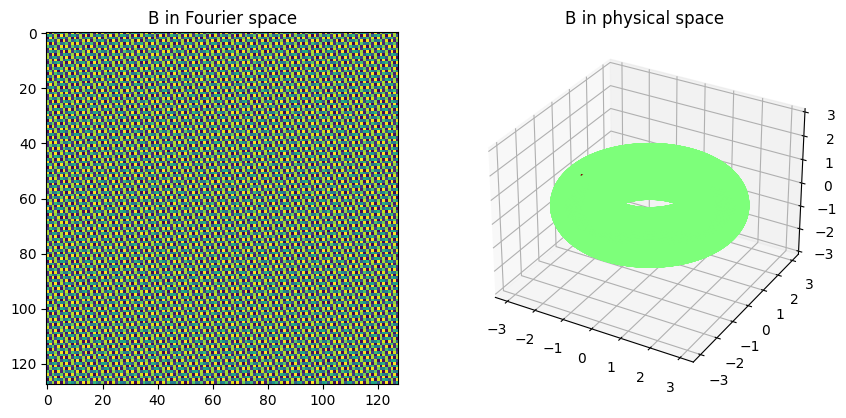

In [4]:
torus.set_point_actuator()

Bhat = torus.Bhat
B = torus.B

# as matrix
fig = plt.figure(figsize=(10,5))
# ax1 = plt.subplot2grid((2,1),(0,0), title='B in physical space')
# ax1.imshow(np.real(B),interpolation='none', aspect='equal')

ax2 = plt.subplot2grid((1,2),(0,0), title='B in Fourier space')
ax2.imshow(np.real(Bhat),interpolation='none', aspect='equal')

# on torus
ax3 = plt.subplot2grid((1,2),(0,1), title='B in physical space', projection='3d')
surface = torus.viz_torus(ax3, B)
# ax4 = plt.subplot2grid((2,2),(1,1), title='B in Fourier space', projection='3d')
# surface = torus.viz_torus(ax4, Bhat.real)

Generate random control sequence and integrate open-loop system to collect
high-dimensional data, for which the underlying low-dimensional dynamics are governed by the above Fourier components.
We also evolve the unforced dynamics for reference.

Evolving continuous-time dynamics without control.
Evolving discrete-time dynamics with or without control.


[Text(0, 0.5, 'u'), Text(0.5, 0, 'Time index')]

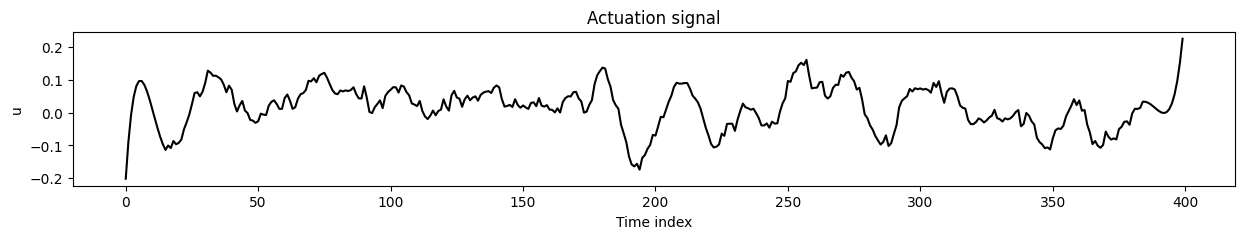

In [5]:
# Random control inputs
U = 0.2*np.random.randn(n_samples)
U = signal.savgol_filter(U, 31, 4)
# U = 0.0001*np.sin(2*np.pi*10*torus.time_vector)

torus.advance(n_samples, dt) # unforced dynamics
Xhat_ct = torus.Xhat
X_unforced = torus.X

# Note the following is overwriting X, Xhat in torus object
torus.advance_discrete_time(n_samples, dt, U) # forced dynamics
Xhat_dt = torus.Xhat 

# note that here: torus.X is updated with force!
# so in the following, you can just torus.X as training data for forced case.


# Show actuation signal
fig = plt.figure(figsize=(15, 2))
ax = fig.add_subplot(111, title = 'Actuation signal')
ax.plot(U,'-', color='black')
ax.set(ylabel=r'u', xlabel='Time index')

Show a realization of the unforced and forced system.

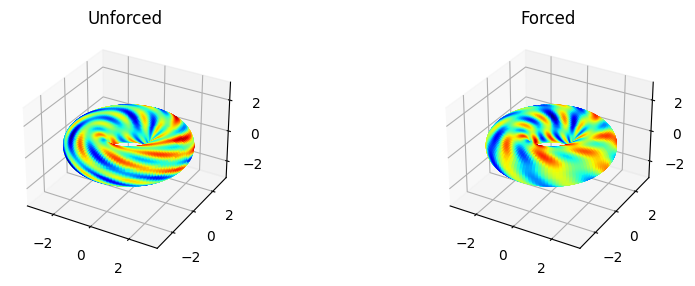

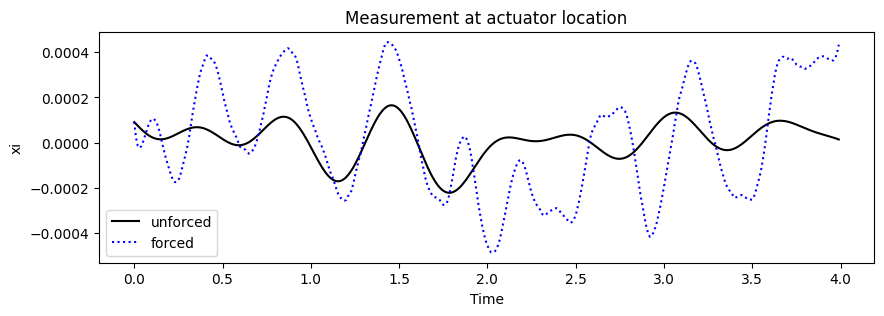

In [6]:
fig = plt.figure(figsize=(10,3))
ax1 = plt.subplot2grid((1,2),(0,0), title='Unforced', projection='3d')
torus.viz_torus(ax1,X_unforced[:,125].reshape(torus.n_states,torus.n_states))

ax2 = plt.subplot2grid((1,2),(0,1), title='Forced', projection='3d')
torus.viz_torus(ax2,torus.X[:,125].reshape(torus.n_states,torus.n_states))

fig = plt.figure(figsize=(10,3))
ax3 = plt.subplot2grid((1,1),(0,0), title='Measurement at actuator location')
measure_at_actuator_location = np.where(torus.B.reshape(n_states**2)!=0)[0]
ax3.plot(torus.time_vector, np.squeeze(X_unforced[measure_at_actuator_location,:]),'-', color='black',label='unforced')
ax3.plot(torus.time_vector, np.squeeze(torus.X[measure_at_actuator_location,:]),':', color='blue',label='forced')
ax3.set(ylabel=r'xi', xlabel='Time')
plt.legend()

Show underlying Fourier components and their time evolution.

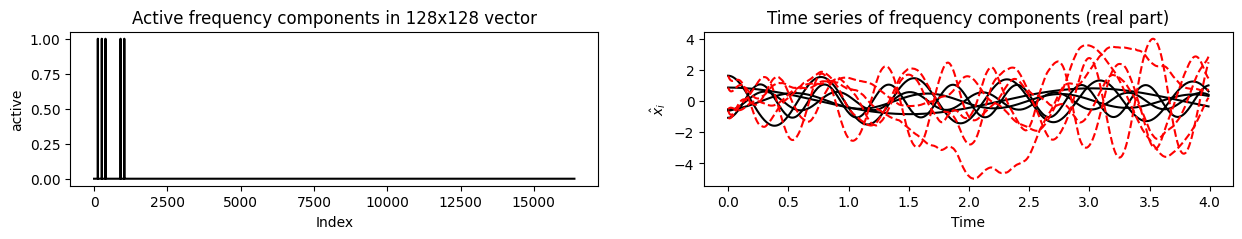

In [7]:
n_states = torus.n_states
xhat_ct = Xhat_ct[torus.mask.reshape(n_states**2)==1,:]
xhat_dt = Xhat_dt[torus.mask.reshape(n_states**2)==1,:]

fig = plt.figure(figsize=(15, 2))
ax = fig.add_subplot(121, title = 'Active frequency components in 128x128 vector')
ax.plot(torus.mask.reshape(n_states**2),'-', color='black')
ax.set(ylabel=r'active', xlabel='Index')

ax = fig.add_subplot(122, title = 'Time series of frequency components (real part)')
ax.plot(torus.time_vector,np.real(xhat_ct.T),'-', color='black', label='no control')
ax.set(ylabel=r'$\hat{x}_i$', xlabel='Time')
ax.plot(torus.time_vector,np.real(xhat_dt.T),'--', color='red', label='with control')

Visualize true Fourier modes, that characterize the system.
Modes are sorted according to spatial frequency.

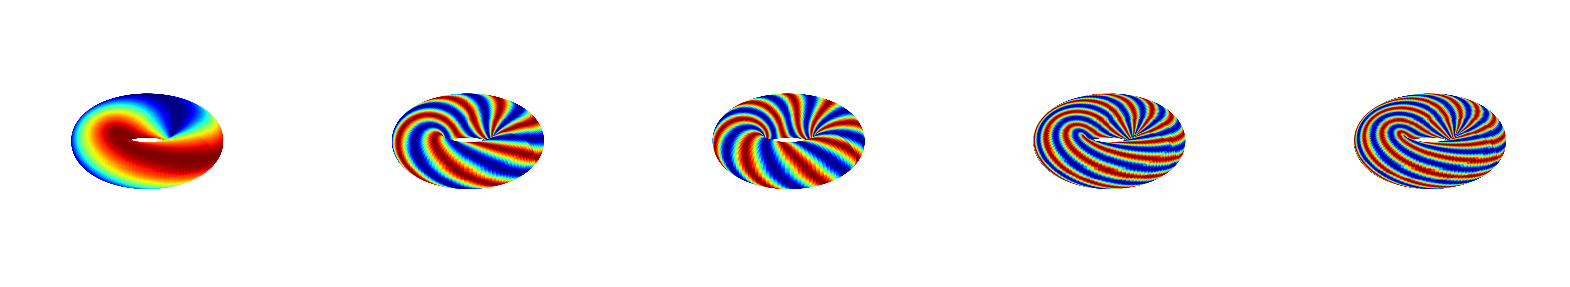

In [8]:
PhiTrue = torus.modes
sorting_index = np.argsort(torus.J[:,0]+torus.J[:,1])
torus.viz_all_modes(np.real(PhiTrue[:,sorting_index]));
# torus.viz_all_modes(np.imag(PhiTrue[:,sorting_index]));

## Applying DMD

The above is just coming from analytic expression. Now data-driven comes in. Apply DMD (without control) to the dataset and visualize the resulting modes, which are not accurately recovered.

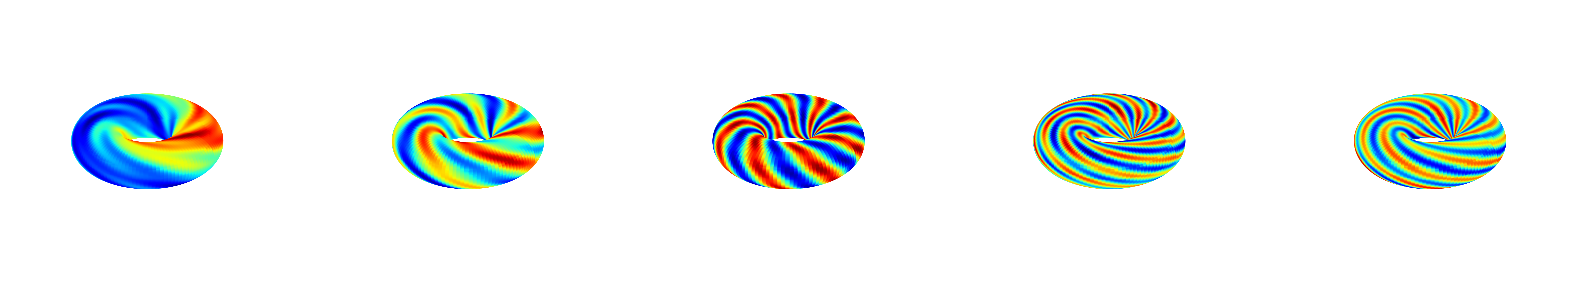

In [9]:
from pydmd import DMD
from pykoopman.regression import PyDMDRegressor

dmd = DMD(svd_rank=10)
model_dmd = pk.Koopman(regressor=PyDMDRegressor(dmd))
model_dmd.fit(torus.X.T)
Phi = model_dmd.W
# modes#regressor.regressor.modes
torus.viz_all_modes(np.real(Phi[:,::2]));
# torus.viz_all_modes(np.imag(Phi[:,::2])); # every other mode as they come in pairs
# clearly, those modes are not the same with the above we got.

## Applying DMD with control

Apply DMDc to the dataset and visualize resulting modes, which are accurately recovered. The one with imaginary modes have really small corresponding amp. 

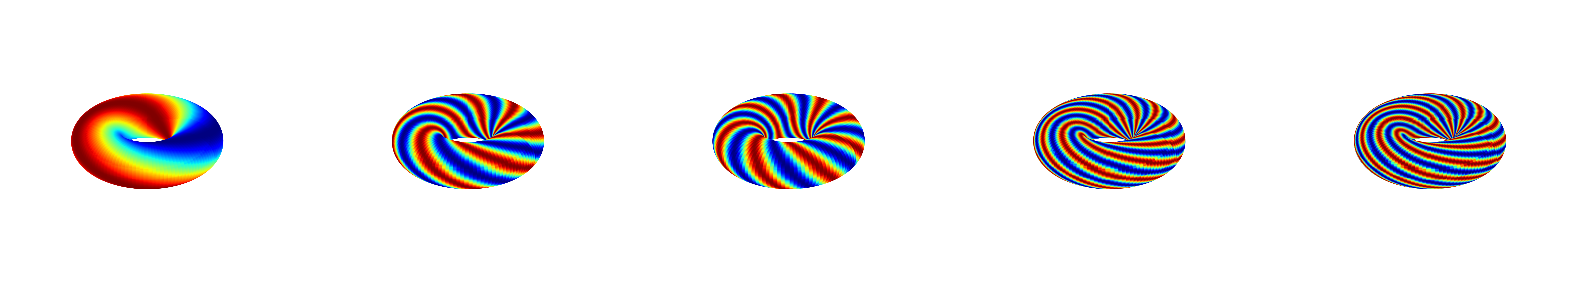

In [10]:
DMDc = pk.regression.DMDc(svd_rank=11, svd_output_rank=10)

model = pk.Koopman(regressor=DMDc)
model.fit(torus.X.T, u=U[:,np.newaxis], dt=dt)

Phi_dmdc = model.W
torus.viz_all_modes(np.real(Phi_dmdc[:,::2]));
# torus.viz_all_modes(np.imag(Phi_dmdc[:,::2]));

Compare the control matrix identified using DMDc with the true control matrix.
Note that the "effective control matrix" must be used for comparison (not the single point actuator),
as the underlying sparse dynamics only consider the control term for the 5 active modes;
other modes are neglected.

True

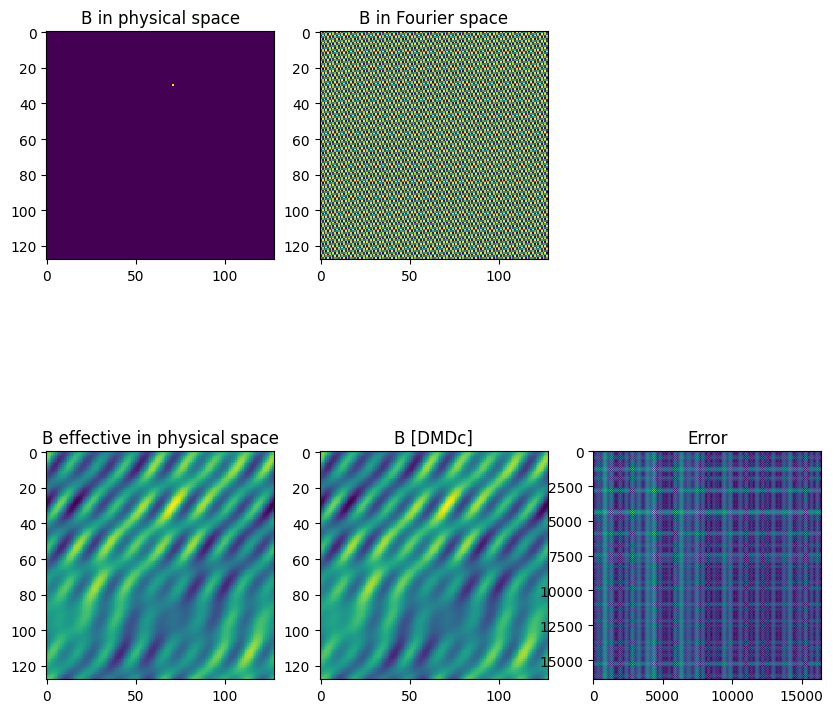

In [11]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((2,3),(0,0), title='B in physical space')
ax1.imshow(np.real(B),interpolation='none', aspect='equal')

ax2 = plt.subplot2grid((2,3),(0,1), title='B in Fourier space')
ax2.imshow(np.real(Bhat),interpolation='none', aspect='equal')

ax3 = plt.subplot2grid((2,3),(1,0), title='B effective in physical space')
ax3.imshow(np.real(torus.B_effective),interpolation='none', aspect='equal')

ax4 = plt.subplot2grid((2,3),(1,1), title='B [DMDc]')

Best = model.ur @ model.B
# Best = model.projection_matrix_output.dot(model.control_matrix)

ax4.imshow(np.real(Best.reshape(torus.n_states,torus.n_states)),interpolation='none', aspect='equal')

Bdiff = abs(torus.B_effective.reshape(torus.n_states**2)-Best)

ax5 = plt.subplot2grid((2,3),(1,2), title='Error')
ax5.imshow(np.real(Bdiff),interpolation='none', aspect='equal')
np.allclose(np.real(torus.B_effective),np.real(Best.reshape(torus.n_states,torus.n_states)))

## Compare the eigenvalues of DMD and DMDc with the true eigenvalues.

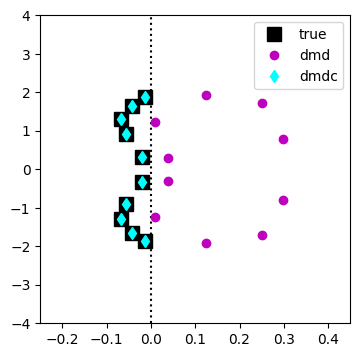

In [12]:
Admd =  model_dmd.A
# model_dmd.regressor.regressor.atilde
Admdc = model.A

evals_dmd, evecs_dmd = np.linalg.eig(Admd)
evals_dmd_cont = np.log(evals_dmd)/dt

evals_dmdc, evecs_dmdc = np.linalg.eig(Admdc)
evals_dmdc_cont = np.log(evals_dmdc)/dt

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(np.array([0,0]), np.linspace(-4,4,2), ':k')
ax.plot(torus.damping, torus.frequencies, 'sk', label='true', markersize=10)
ax.plot(torus.damping, -torus.frequencies, 'sk', markersize=10)
ax.plot(evals_dmd_cont.real, evals_dmd_cont.imag/(2*np.pi), 'mo', label='dmd')
ax.plot(evals_dmdc_cont.real, evals_dmdc_cont.imag/(2*np.pi), 'd', color='cyan', label='dmdc')
ax.set_xlim(-0.25,0.45)
ax.set_ylim(-4,4)
ax.legend()